In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from pyimagesearch.convautoencoder import ConvAutoencoder

import os
import pickle
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

# Summer precipitation anomaly detection using Autoencoder

In [3]:
prec_f = xr.open_dataarray('dataset/APHRO_050deg_1961_2015.nc')
prec_f = prec_f.sel(time = slice('1981','2015'))

# calculate precipitation climatological dafrom matplotlib import pyplot as pltily mean
prec_1981_2000 = prec_f.sel(time = slice('1981','2000'))
prec_clim = prec_1981_2000.groupby('time.dayofyear').mean()

# calculate daily precipitation anomalies
prec_ano = prec_f.groupby('time.dayofyear') - prec_clim

# calculate 5-day running-average anomalies to remove the effect of short-term synoptic weather
prec_array = prec_ano.values
prec_array = (prec_array[:-4,:,:] + prec_array[1:-3,:,:] + prec_array[2:-2,:,:] + prec_array[3:-1,:,:] + prec_array[4:,:,:]) / 5
prec_ano[2:-2,:,:] = prec_array

# only select summer time data
prec_ano = prec_ano.sel(time = np.in1d(prec_ano['time.month'], [5,6,7,8,9,10]))
prec_ano.to_netcdf('dataset/APHRO_summer_anomalies_1981_2015_fixed.nc')

# Normalzied dataset

In [3]:
# original shape of prec_ano
print(prec_ano.dims,prec_ano.shape)

lons = prec_ano['lon']
lats = prec_ano['lat']

### set miss values as zeros
prec_ano = prec_ano.values
prec_ano = np.nan_to_num(prec_ano, copy=True, nan=0)

### Normalize
print ("data.min()=",prec_ano.min())
print ("data.max()=",prec_ano.max())

minvalue = -20
maxvalue = 120
prec_norm = (prec_ano.squeeze() - minvalue)/(maxvalue - minvalue)
print ("data_norm.min()=",prec_norm.min())
print ("data_norm.max()=",prec_norm.max())
print (np.shape(prec_norm))

('time', 'lat', 'lon') (6440, 70, 123)
data.min()= -19.595477564483883
data.max()= 125.25223902061582
data_norm.min()= 0.0028894459679722675
data_norm.max()= 1.037515993004399
(6440, 70, 123)


In [4]:
# date for training
ts = pd.date_range(start='1981-01-01',end='2015-12-31',freq='D')
ts = ts.strftime('%Y%m%d')
dates = pd.to_datetime(ts, format='%Y%m%d')

# padding for training convinient

In [5]:
padwidth1 = ((0,0),(1,1),(2,3))
prec_norm_img_list = np.pad(prec_norm, pad_width=padwidth1,mode='constant',constant_values=0)
prec_norm_img_list = np.expand_dims(prec_norm_img_list, axis=-1)

time_max, lat_max, lon_max, zmax = np.shape(prec_norm_img_list)
print('Shape of input dataset: ', prec_norm_img_list.shape)

Shape of input dataset:  (6440, 72, 128, 1)


# split training and testing data

In [6]:
train_data, test_data, = train_test_split(prec_norm_img_list, test_size=0.2, random_state=1)
print('Training data shape: ', train_data.shape)
print('Testing data shape: ',test_data.shape)

Training data shape:  (5152, 72, 128, 1)
Testing data shape:  (1288, 72, 128, 1)


# Autoencoder training for train_data

In [7]:
### initialize deep learning parameters
EPOCHS = 10
INIT_LR = 1e-3
BS = 10

In [8]:
### construct convolutional autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(width=lon_max,height=lat_max,depth=zmax,filters=(32,64,128),latentDim=64)
opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
autoencoder.compile(loss='mse',optimizer=opt)

## train the convolutional autoencoder

In [9]:
H = autoencoder.fit(
    train_data,train_data,
    validation_data=(test_data,test_data),
    epochs=EPOCHS,
    batch_size=BS
)

Epoch 1/10


2022-12-08 17:06:19.264948: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


516/516 [==============================] - 43s 82ms/step - loss: 0.0195 - val_loss: 0.0153
Epoch 2/10
516/516 [==============================] - 41s 79ms/step - loss: 0.0083 - val_loss: 1.9022e-04
Epoch 3/10
516/516 [==============================] - 40s 78ms/step - loss: 1.7287e-04 - val_loss: 1.7723e-04
Epoch 4/10
516/516 [==============================] - 40s 77ms/step - loss: 1.7174e-04 - val_loss: 1.7424e-04
Epoch 5/10
516/516 [==============================] - 39s 76ms/step - loss: 1.7160e-04 - val_loss: 1.7243e-04
Epoch 6/10
516/516 [==============================] - 40s 77ms/step - loss: 1.7135e-04 - val_loss: 1.7334e-04
Epoch 7/10
516/516 [==============================] - 40s 78ms/step - loss: 1.7099e-04 - val_loss: 1.7323e-04
Epoch 8/10
516/516 [==============================] - 44s 84ms/step - loss: 1.1603e-04 - val_loss: 9.6861e-05
Epoch 9/10
516/516 [==============================] - 41s 79ms/step - loss: 6.6361e-05 - val_loss: 6.6305e-05
Epoch 10/10
516/516 [============

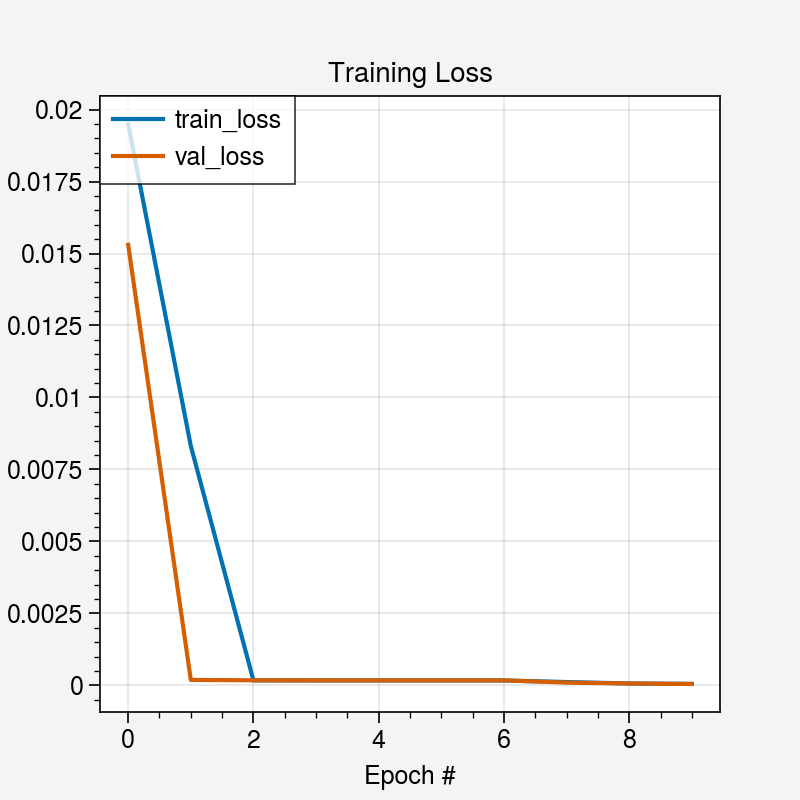

In [10]:
# Loss function plot
N = np.arange(0,10)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()    

# Save trained autoencoder model

In [11]:
autoencoder.save('autoencoder/processed_data/autoencoder_trained_APHRO_1981_2015_fixed.model',save_format='h5')

# Load trained autoencoder model

In [12]:
autoencoder = load_model('autoencoder/processed_data/autoencoder_trained_APHRO_1981_2015_fixed.model')

# Compute error

In [13]:
def comp_error(images, autoencoder):
    time_max,_,_,_ = np.shape(images)
    errors_ = np.zeros(time_max)
    recons_ = autoencoder.predict_on_batch(images)
    for tt in range(time_max):
        errors_[tt] = np.mean((images[tt] - recons_[tt])**2)
    del(recons_)
    return errors_

In [14]:
errors_all = []
for i in range(len(prec_norm_img_list)//100+1):
    if i != len(prec_norm_img_list)//100:
        errors = comp_error(prec_norm_img_list[i*100:i*100+100], autoencoder)
    else:
        errors = comp_error(prec_norm_img_list[i*100:], autoencoder)
    errors_all = errors_all + errors.tolist()

In [15]:
### save error
with open("autoencoder/processed_data/error_APHRO_1981_2015_fixed.pickle", mode="wb") as f:
    pickle.dump(errors_all, f)

In [16]:
## load error
f = open('autoencoder/processed_data/error_APHRO_1981_2015_fixed.pickle', mode="rb")
errors = pickle.load(f)
errors = np.array(errors)

In [17]:
### compute the 95th percentile of the errors as the threshold to identify anomalies
thresh = np.quantile(errors, 0.95)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 9.065326012929822e-05
[INFO] 322 outliers found


# Ploting anomalous precipitation day

In [18]:
def pad_remover(rdata,multidata=False):
    ndim = rdata.ndim
    if ndim==4:
        if multidata:
            recon = rdata[:,1:-1,2:-3,0] # padwidth1 = ((0,0),(1,1),(2,3))
        else:
            recon = rdata[0,1:-1,2:-3,0]
    elif ndim==3:
        recon = rdata[1:-1,2:-3,0]

    return recon

In [19]:
dates_summer = dates[((dates.month > 4) & (dates.month < 11))]

# Determine winner

In [2]:
from minisom import MiniSom
from scipy.spatial import distance

def determine_winner(prec_ano_data):

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 80000) 
    winners = []
   
    for i in range(len(data_stack)):
        dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
        dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
        dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
        dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
        dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
        dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
        dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6])
        winner = dists.argmin()
        winners.append(winner)

    return winners

In [7]:
prec_ano = xr.open_dataarray('dataset/APHRO_summer_anomalies_1981_2015_fixed.nc')
ano_date = pd.read_csv('output/ano_dates_95th_APHRO_1981_2015_fixed.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

winner = determine_winner(prec_ano_95th)
winner_obs = pd.Series(winner,index=ano_date)
winner_obs.to_csv('output/winner_APHRO_1981_2015_fixed.csv')

# Time series of observed anomalous days

0.557142857142857 4.895273970169975e-06


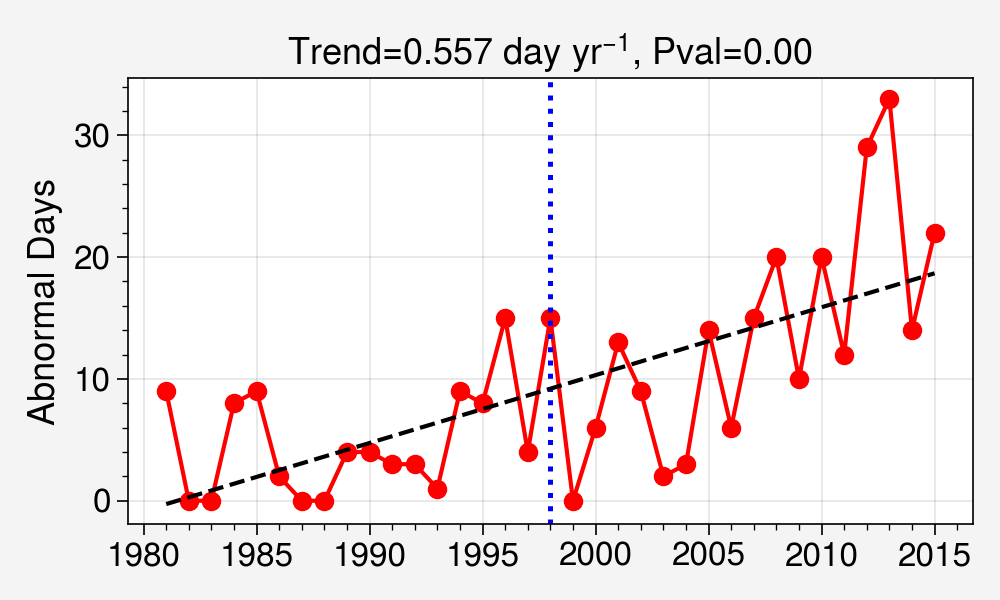

In [21]:
# Time series for anomalous days (using 95th)
ano_dates = dates_summer[idxs]
idxs_pd = pd.Series(idxs)
idxs_pd.index = ano_dates
idxs_pd.to_csv('output/ano_dates_95th_APHRO_1981_2015_fixed.csv')

fig, ax = plt.subplots(figsize=(5,3))

ano_freq = ano_dates.year.value_counts().reindex(dates.year.unique(),fill_value=0).sort_index()
ano_freq.to_csv('output/ano_freq_95th_APHRO_1981_2015_fixed.csv')

# Plot
years = ano_freq.index
plt.plot(years, ano_freq, "o-", color="r")
plt.axvline(x=1998,color='blue',linewidth=1.8,ls=':')
plt.tick_params(axis='y',colors='black',labelsize = 12)
plt.tick_params(axis='x',colors='black',labelsize = 12)

trend = linregress(years,ano_freq).slope
pval = linregress(years,ano_freq).pvalue
intercept = linregress(years,ano_freq).intercept
print (trend,pval)

if pval <=0.05:
    yy = years * trend + intercept
    plt.plot(years, yy, "--", color="black")
    plt.title("Trend=%.3f day yr$^{-1}$, Pval=%.2f" % (trend,pval),fontdict={'fontsize':13})
else:
    plt.title("Pvalue=%.2f" % (pval))
ax.set_ylabel('Abnormal Days',fontdict={'fontsize':13})

plt.tight_layout()
plt.savefig("figure/abnormal_frequency_time_series_APHRO_1981_2015_fixed.pdf")